# Try again with CNN with Gramian Angular Difference Field
# Produce a dataset containing EventID that correspond to ...

In [17]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import sys
from pyts.transformation import GADF,GASF
from pyts.visualization import plot_gasf

# plt.rcParams['figure.figsize'] = 12.0, 8.0

# arguments = sys.argv
# Run = arguments[0]
# SubRun = arguments[1]
# SubSubRun = arguments[2]

file = "Run9goodDataQ_dualgate.root"#.format(Run,SubRun,SubSubRun)
# file = "Run009/Run009-070-001.root"#.format(Run,SubRun,SubSubRun)
data = "PMTALL"
tree = "tree"
energy1 = "Energy"

CPU times: user 44 µs, sys: 1e+03 ns, total: 45 µs
Wall time: 51 µs


In [2]:
%%time
from pyts.transformation import GADF, GASF

from sklearn.preprocessing import normalize
from root_numpy import tree2array,array2tree,array2root
import ROOT
import keras

# Slightly different , just the first 4096 of waveform(full 4480, for ease of operations)
def reader_pmt(path):
    extra = np.arange(4096, 4480)
    x_file = ROOT.TFile(path)
    x_tree = x_file.Get("tree")
    x_pmtall = tree2array(x_tree, branches="PMTALL")
    x = np.delete(x_pmtall, extra, axis=1)
    return x

def reader_para(path,para1,z):
    x_file =  ROOT.TFile(path)
    x_tree = x_file.Get("tree")
    x1 = tree2array(x_tree, branches=para1 )
    x = x1[:,z]
    return x

def reader_para1(path,para1,z):
    x_file =  ROOT.TFile(path)
    x_tree = x_file.Get("tree")
    x1 = tree2array(x_tree, branches=para1 )
    return x1

def viewer(x):
    y = abs(x-15200)
    z = normalize(y, norm="l1")
    return z

# import random

def generator(path):
    pmtall = reader_pmt(path)
    ratio4us = reader_para1(path,"Ratio4us",0)
    pmtall_norm = viewer(pmtall)
    energy = reader_para(path,"Energy",1)
    dataquality0 = reader_para(path,"DataQuality",0)
    dataquality1 = reader_para(path,"DataQuality",1)
    dataquality2 = reader_para(path,"DataQuality",2)
    dataquality3 = reader_para(path,"DataQuality",3)
    psdpara1 = reader_para(path,"PSDPara",1)
    psdpara7 = reader_para(path,"PSDPara",7)
    psdpara13 = reader_para(path,"PSDPara",13)
    psdpara22 = reader_para(path,"PSDPara",22)
    triggercounter33 = reader_para(path,"TriggerCounter",33)
    triggercounter36 = reader_para(path,"TriggerCounter",36)
    crystaln = reader_para(path,"CrystalN",0)
    position = reader_para(path,"Position_wm",1)
    ratio = reader_para1(path,"Ratio",0)
    timingdiff = reader_para1(path,"TimingDiff",0)

#         print(ratio4us.shape,pmtall.shape,psdpara1.shape)
    gasf = GASF(image_size=128, overlapping=False, scale='-1')
    length = len(ratio)

    while 1:
        for i in range(length):
                p = np.expand_dims(pmtall[i],axis=0)
                p = gasf.transform(p)
                r = np.expand_dims(pmtall_norm[i],axis=0)
                w = np.array([ratio4us[i],energy[i],psdpara1[i],psdpara7[i],psdpara13[i],psdpara22[i],crystaln[i],position[i],ratio[i],timingdiff[i]])
                s = np.expand_dims(w,axis=0)
                yield [r,p,s]
                
                
test = generator(file)
print(next(test)[0].shape,next(test)[1].shape,next(test)[2].shape)



Welcome to JupyROOT 6.10/02


/Users/hareyakana/Documents/root/lib/ROOT.py:318: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _orig_ihook( name, *args, **kwds )
Using TensorFlow backend.


(1, 4096) (1, 128, 128) (1, 10)
CPU times: user 18.4 s, sys: 5.07 s, total: 23.4 s
Wall time: 27.9 s


##### label = 0

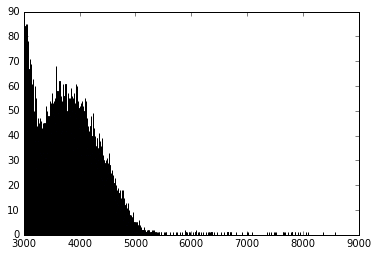

CPU times: user 33.3 s, sys: 4.21 s, total: 37.5 s
Wall time: 37.9 s


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '
2018-03-12 13:06:22.668613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:856] OS X does not support NUMA - returning NUMA node zero
2018-03-12 13:06:22.669288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1030] Found device 0 with properties: 
name: GeForce GT 650M major: 3 minor: 0 memoryClockRate(GHz): 0.405
pciBusID: 0000:01:00.0
totalMemory: 511.69MiB freeMemory: 275.77MiB
2018-03-12 13:06:22.669337: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1120] Creating TensorFlow device (/device:GPU:0) -> (device: 0, name: GeForce GT 650M, pci bus id: 0000:01:00.0, compute capability: 3.0)


In [3]:
%%time

rfile = ROOT.TFile(file)
intree = rfile.Get(tree)
treer = tree2array(intree)
# pmtall = tree2array(intree, branches=data)
energy = tree2array(intree, branches=energy1)

plt.figure()
plt.hist(energy[:,1],bins=np.arange(3000,9000,1))
plt.show()

from keras.models import load_model

model = load_model("GPU_CNN.h5")

steps=len(energy)


In [4]:
pred = model.predict_generator(generator(file),max_queue_size=100,steps=steps,verbose=1)

twomax = np.argsort(pred)
print(twomax.shape)
uncertain = np.zeros(steps)

for i in range(steps):
    uncertain[i] = pred[i][twomax[i,4]] - pred[i][twomax[i,3]]

print(uncertain)

indices = np.argmax(pred,axis=1)

65675/65675 [==============================] - 875s 13ms/step
(65675, 7)
[4.00197657e-15 4.85179625e-15 4.83820137e-15 ... 4.83811836e-15
 3.72236818e-02 1.78812165e-02]


Starts picking!
picked 34180 events!


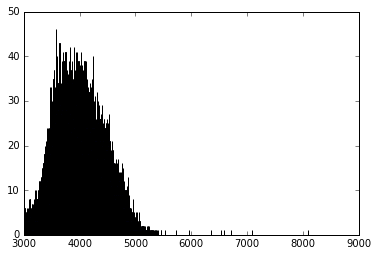

In [5]:
print("Starts picking!")
picked0 = []
for i in range(len(energy)):
    if indices[i]==0 and uncertain[i]<0.1: #and pred[i][0]>0.9:
        picked0.append(i)
#         plt.figure()
#         plt.plot(np.arange(4096),pmtall[i])
#         plt.show()

# histogramming = treer[picked]
# array2root(histogramming, "PSD15out.root","tree")#.format(Run,SubRun,SubSubRun), "tree")

print("picked",len(picked0), "events!")
plt.figure()
plt.hist(energy[picked0,1],bins=np.arange(3000,9000,1))
plt.show()

### checking

In [6]:
# Augment pmtall waveform for better viewing frame instead of inverted.
pmtall = reader_pmt(file)
pmtall = viewer(pmtall)


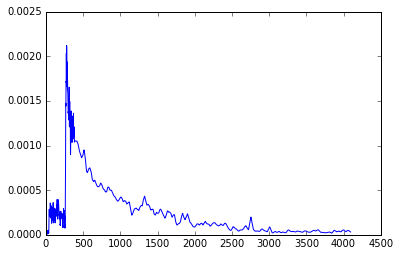

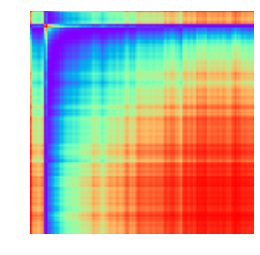

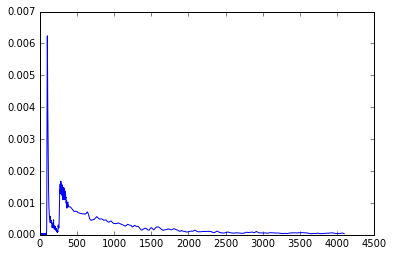

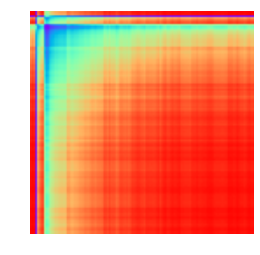

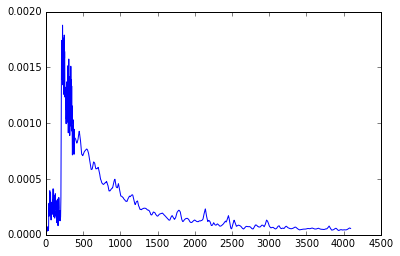

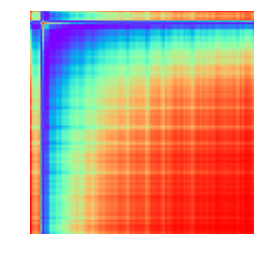

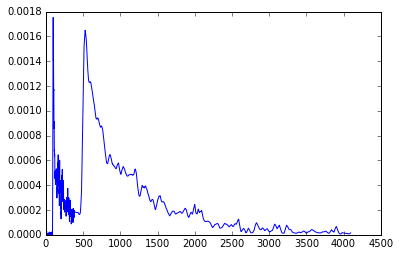

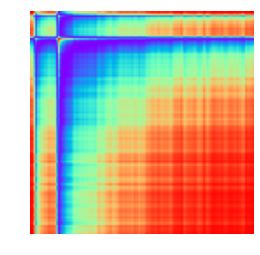

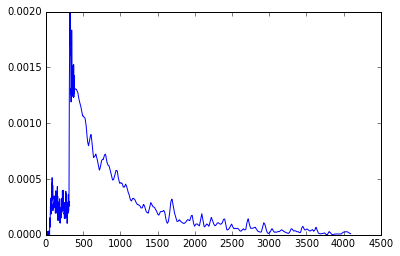

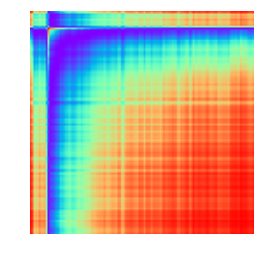

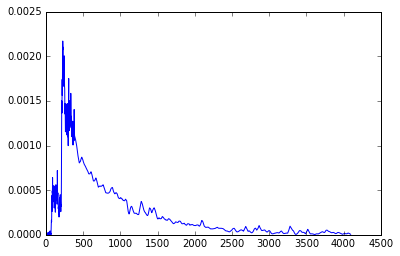

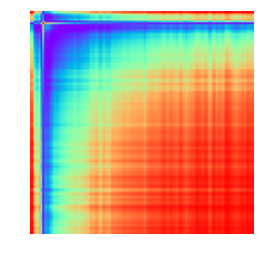

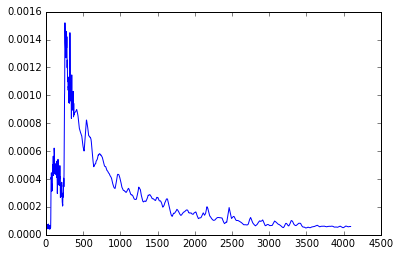

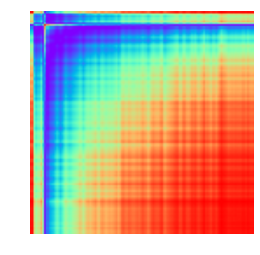

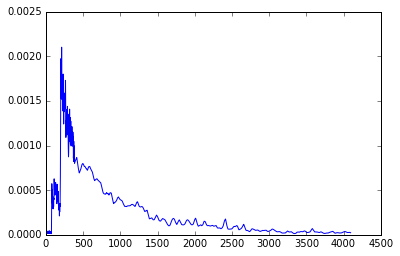

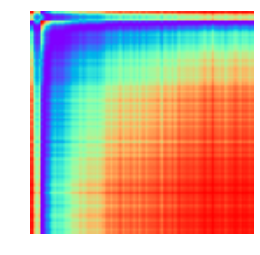

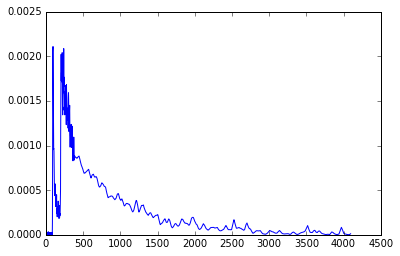

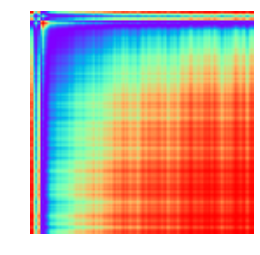

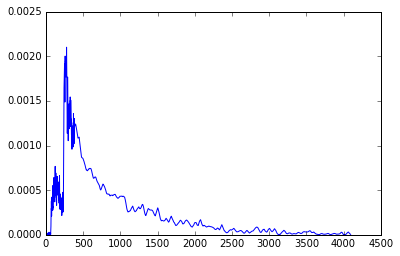

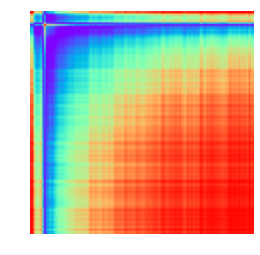

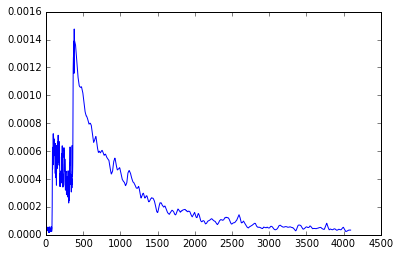

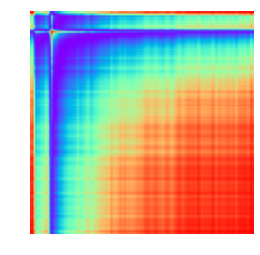

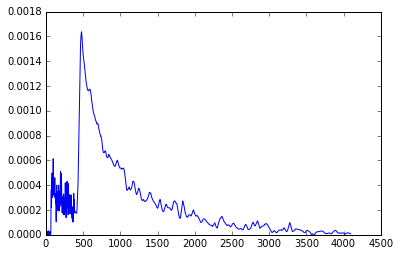

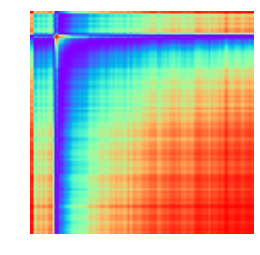

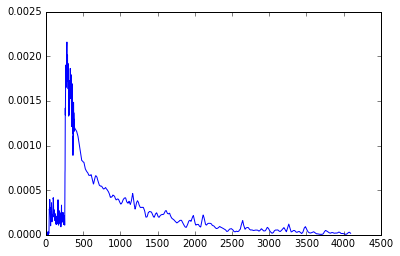

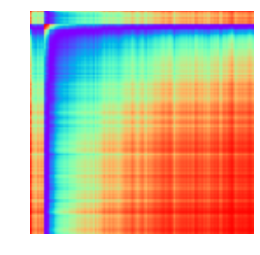

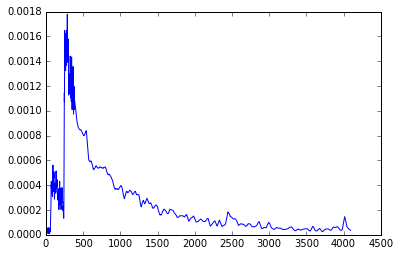

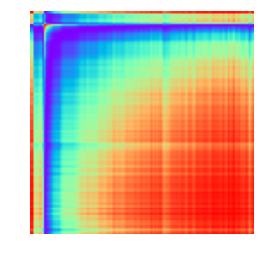

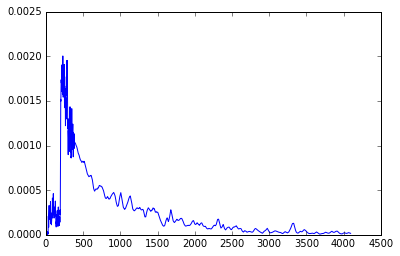

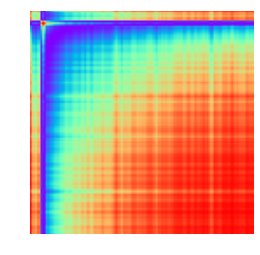

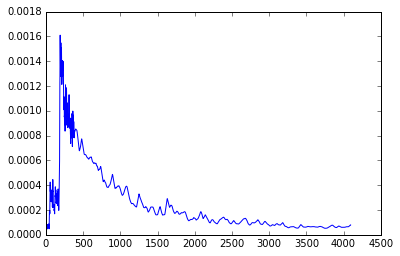

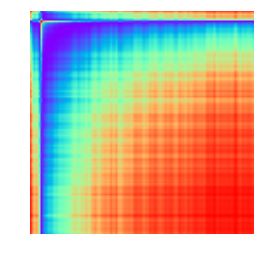

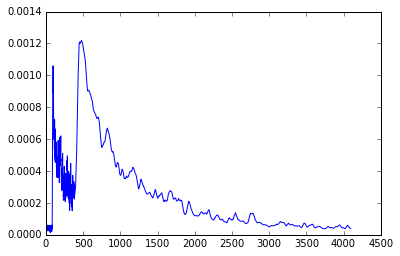

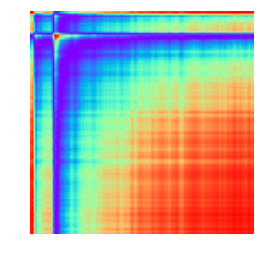

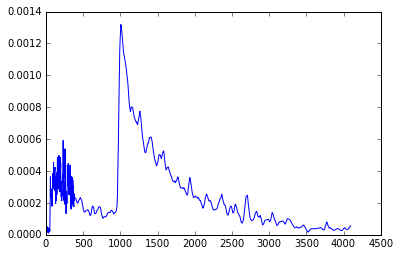

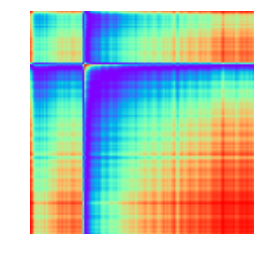

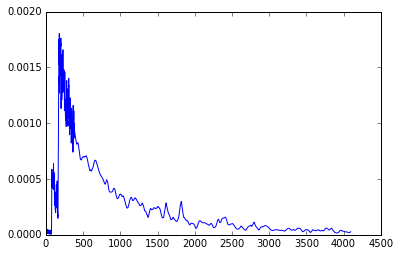

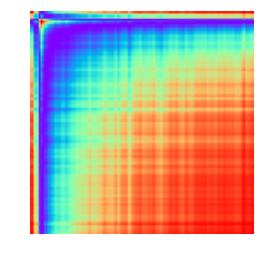

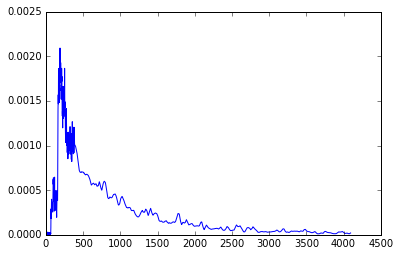

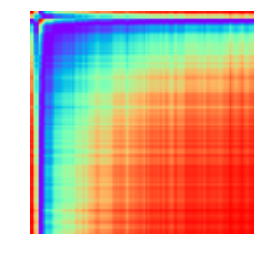

In [25]:
for i in range(20):
    k = np.random.randint(len(picked0))
    plt.figure()
    plt.plot(np.arange(4096),pmtall[picked0[k]])
    plt.savefig("plots/dp_{}.png".format(i))
    plt.show()
    plt.figure()
    plot_gasf(pmtall[picked0[k]], image_size=128, overlapping=False, scale='-1')
    plt.savefig("gasf/dp_{}".format(i))
    plt.show()
    
# plt.figure()
# plt.plot(np.arange(4096),pmtall[picked0[0]])
# plt.savefig("waveform.png")
# plt.show()

# plt.figure()
# plt.plot(np.arange(4096),pmtall[picked0[i]])
# plt.show()

##### label = 1

Starts picking!


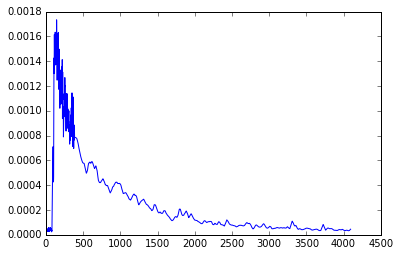

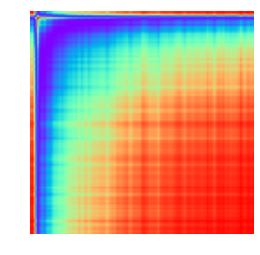

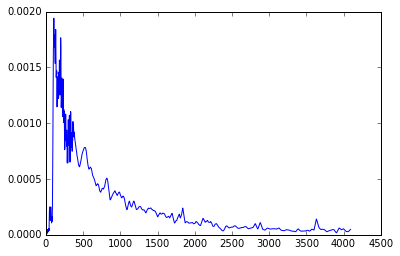

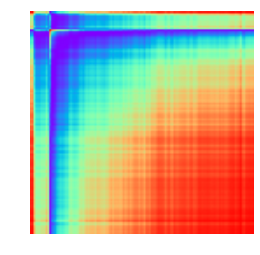

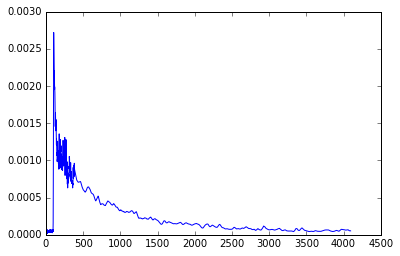

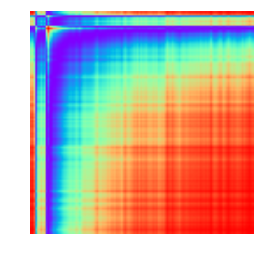

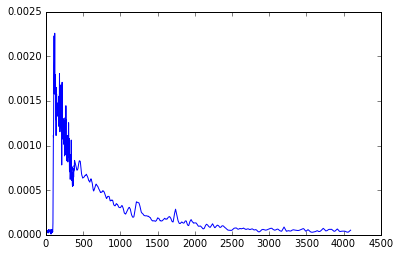

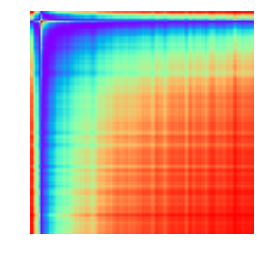

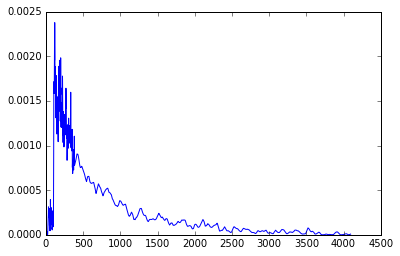

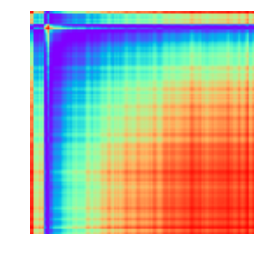

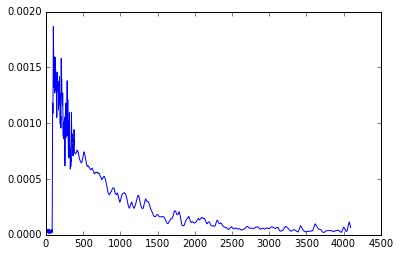

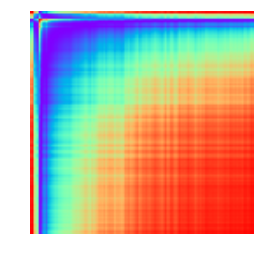

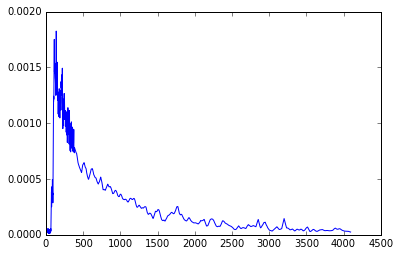

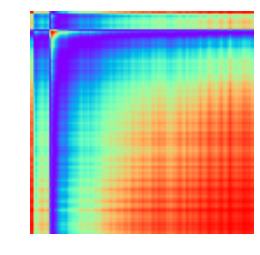

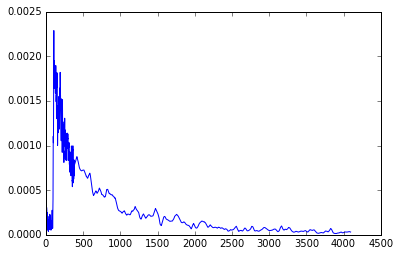

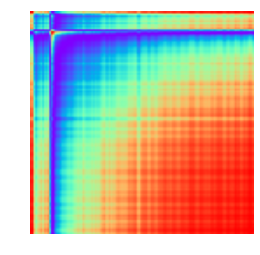

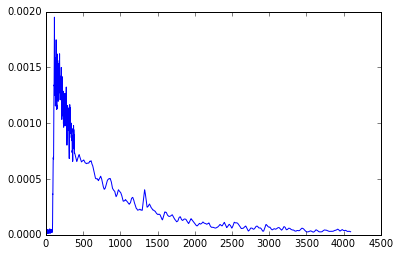

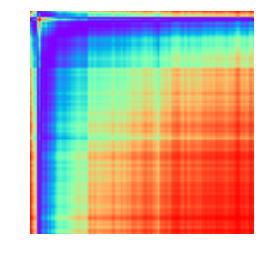

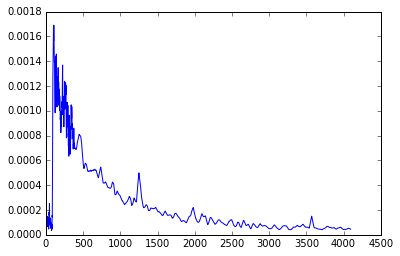

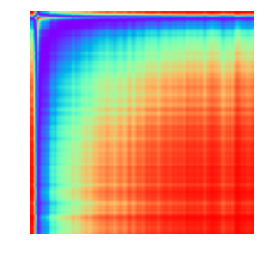

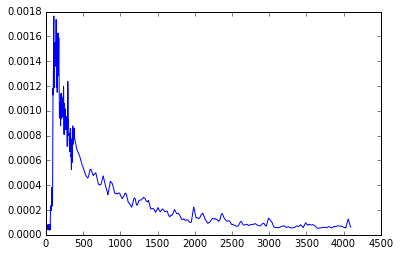

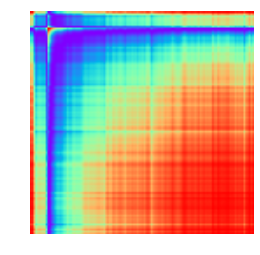

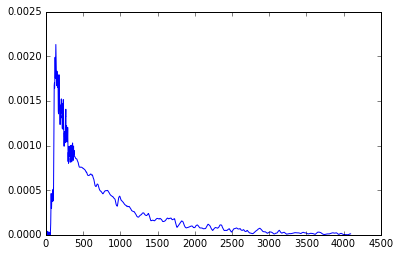

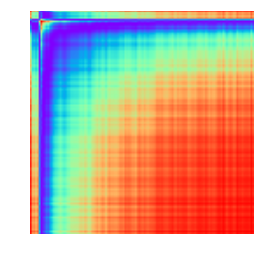

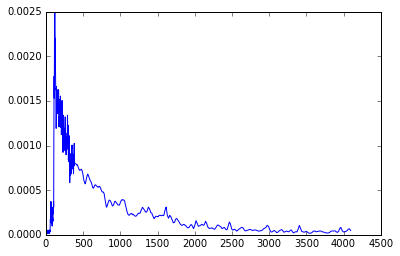

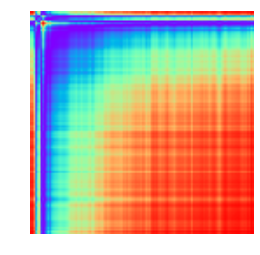

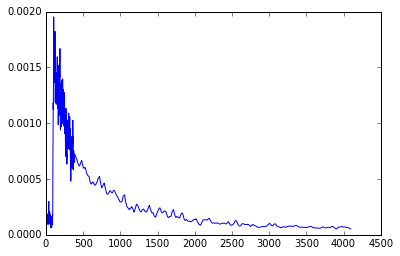

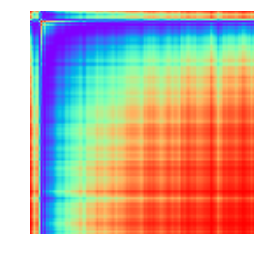

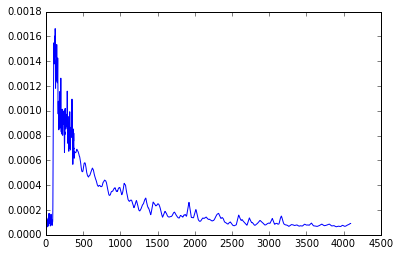

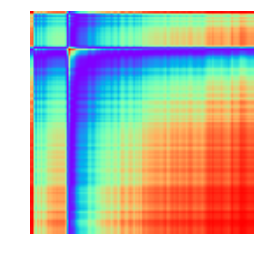

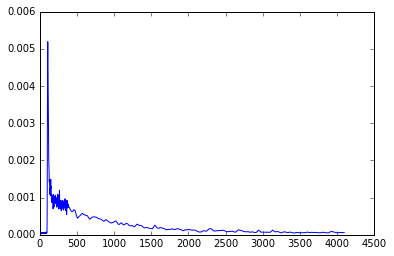

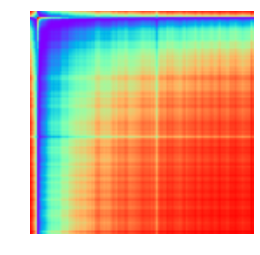

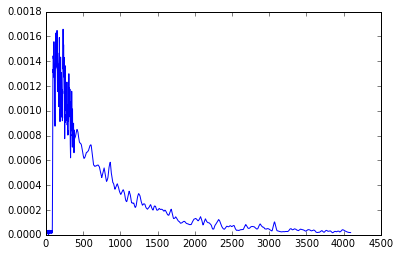

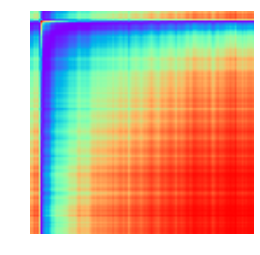

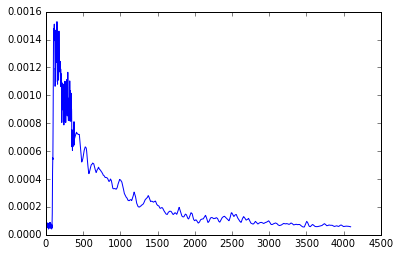

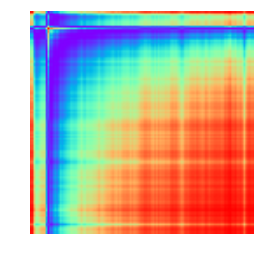

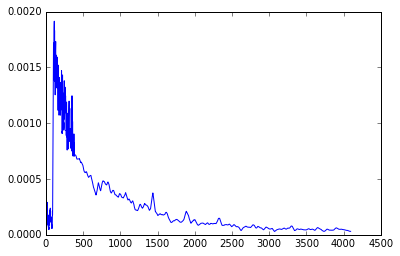

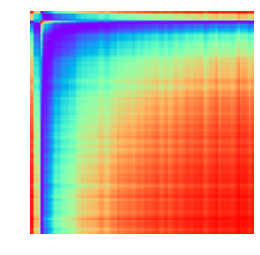

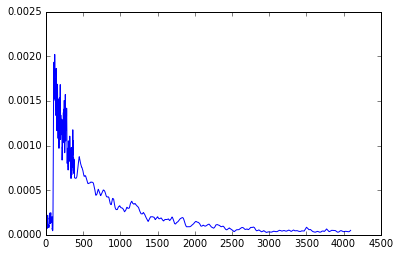

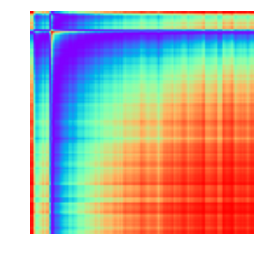

picked 15302 events!


In [26]:
print("Starts picking!")
picked1 = []
for i in range(len(energy)):
    if indices[i]==1 and uncertain[i]<0.1: #and pred[i][0]>0.9:
        picked1.append(i)

for i in range(20):
    k = np.random.randint(len(picked1))
    plt.figure()
    plt.plot(np.arange(4096),pmtall[picked1[k]])
    plt.savefig("plots/ref_{}.png".format(i))    
    plt.show()
    plt.figure()
    plot_gasf(pmtall[picked0[k]], image_size=128, overlapping=False, scale='-1')
    plt.savefig("gasf/ref_{}".format(i))
    plt.show()
    
print("picked",len(picked1), "events!")


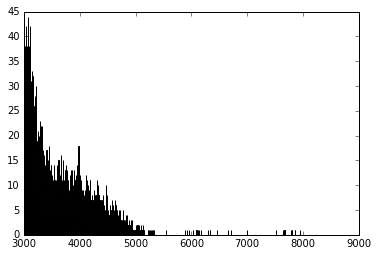

In [9]:
plt.figure()
plt.hist(energy[picked1,1],bins=np.arange(3000,9000,1))
plt.show()

##### label = 2

Starts picking!


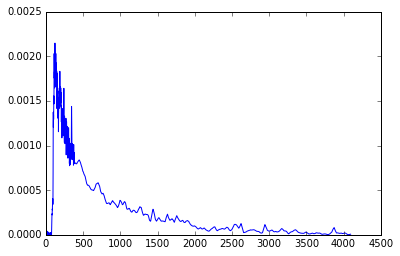

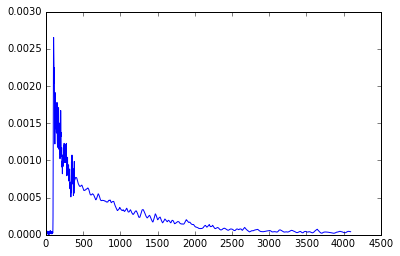

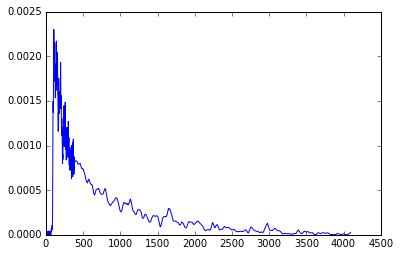

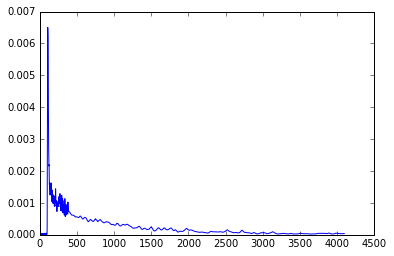

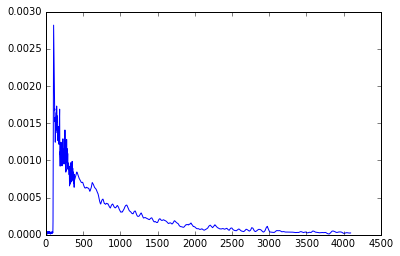

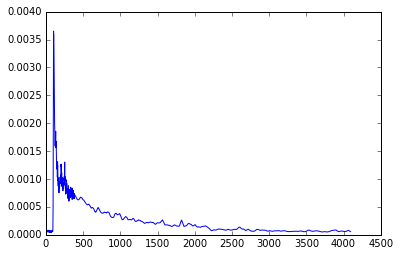

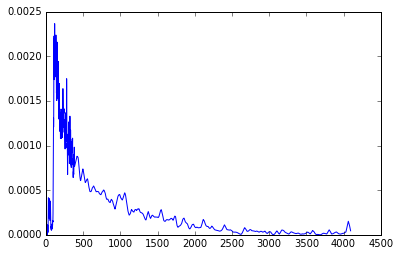

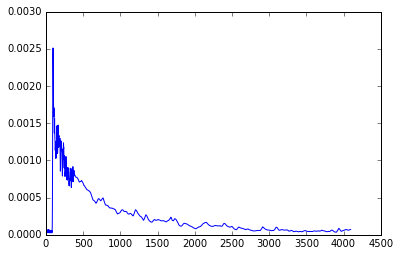

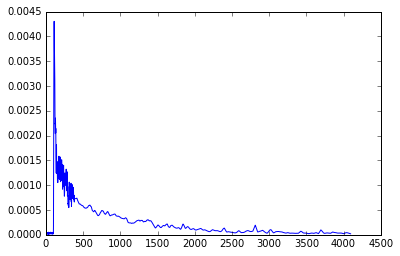

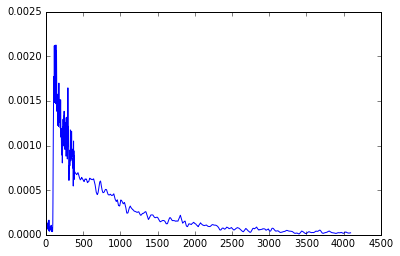

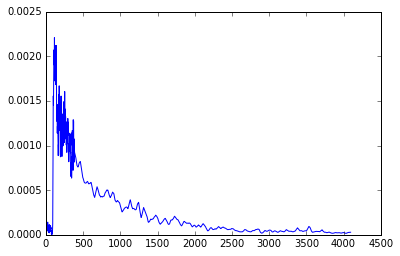

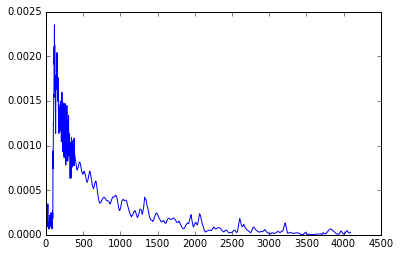

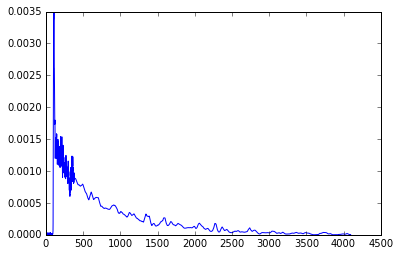

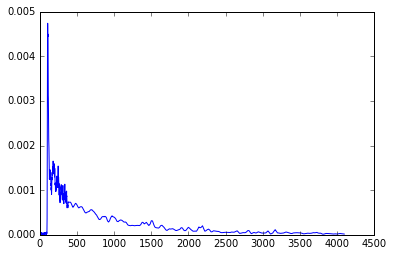

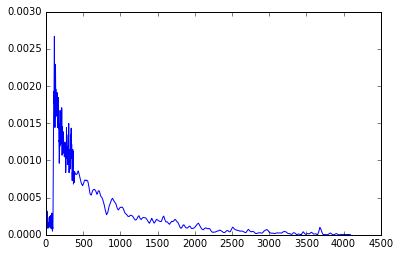

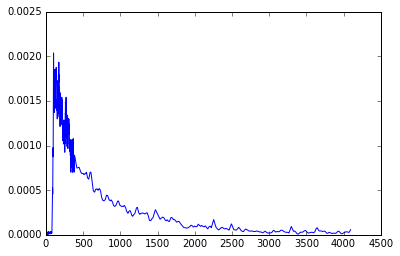

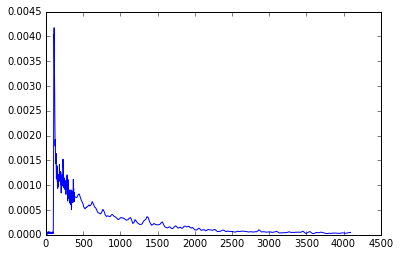

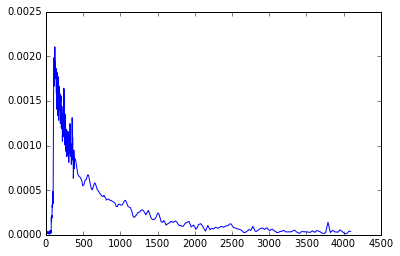

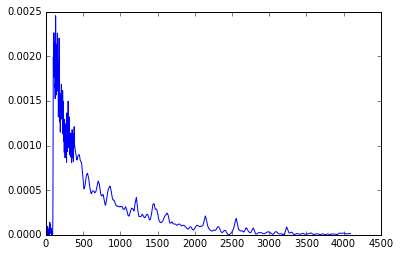

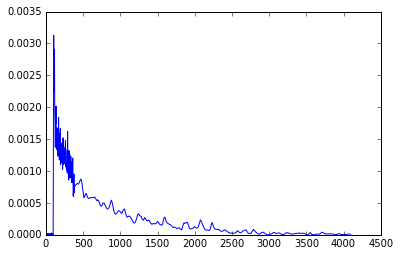

picked 8751 events!


In [10]:
print("Starts picking!")
picked2 = []

for i in range(len(energy)):
    if indices[i]==2 and uncertain[i]<0.1:
        picked2.append(i)

for i in range(20):
    k = np.random.randint(len(picked2))
    plt.figure()
    plt.plot(np.arange(4096),pmtall[picked2[k]])
#     plt.savefig("plots/lsbe_{}.png".format(i))
    plt.show()
print("picked",len(picked2), "events!")

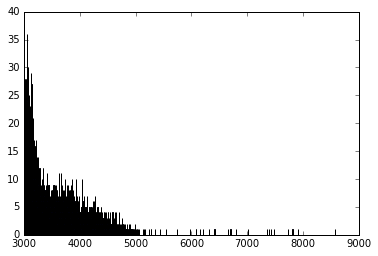

In [11]:
plt.figure()
plt.hist(energy[picked2,1],bins=np.arange(3000,9000,1))
plt.show()

##### label = 3

Starts picking!


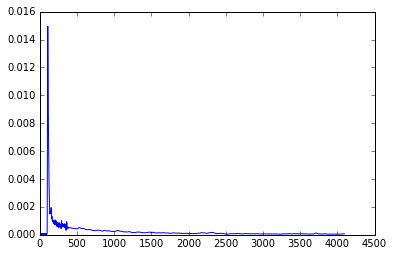

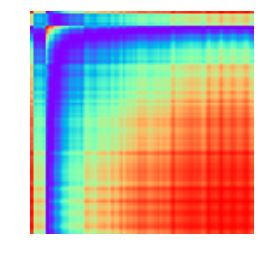

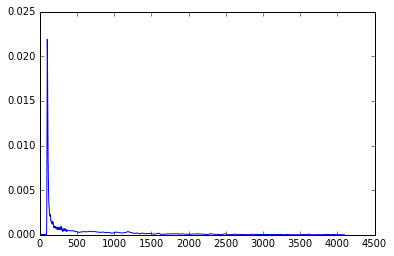

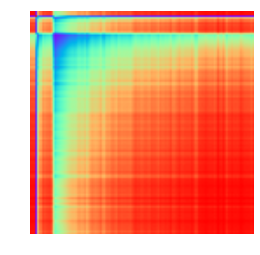

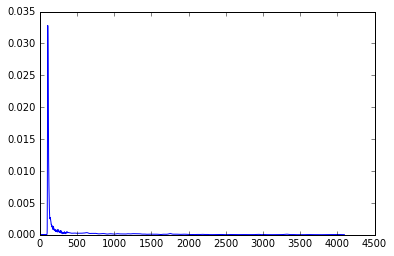

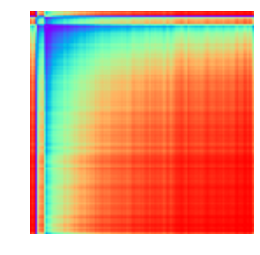

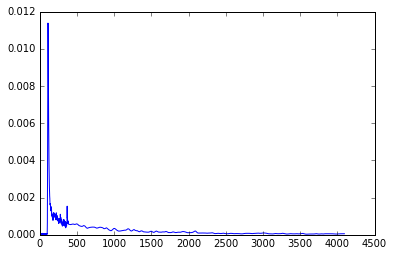

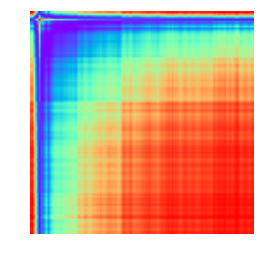

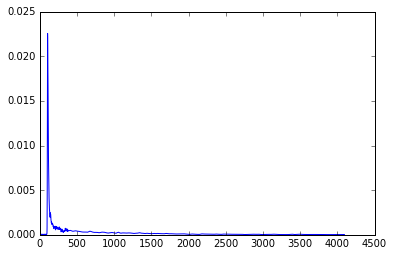

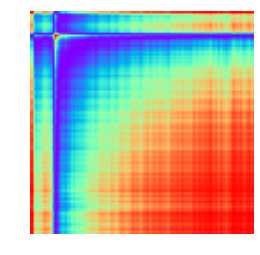

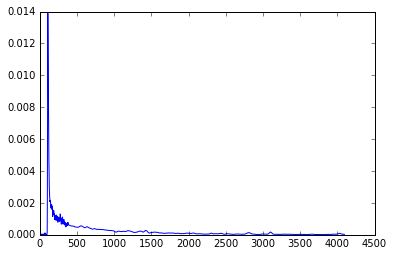

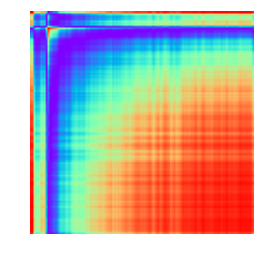

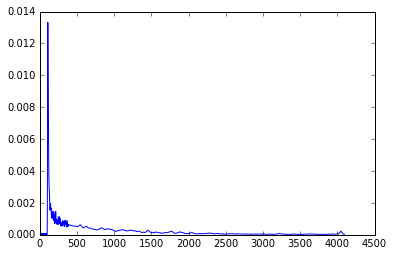

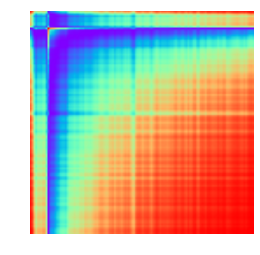

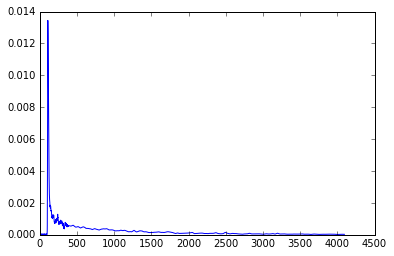

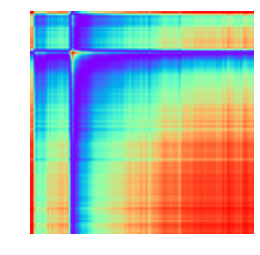

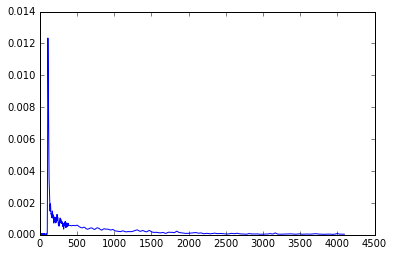

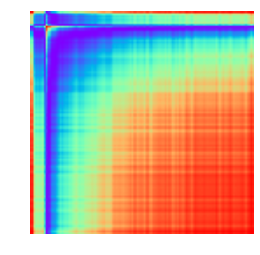

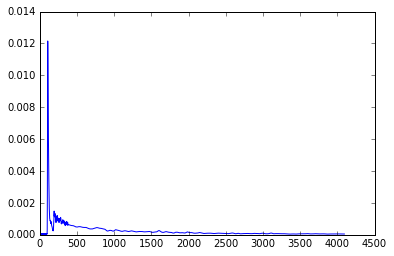

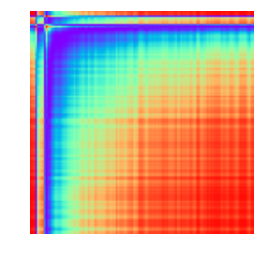

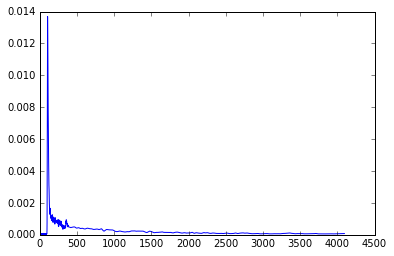

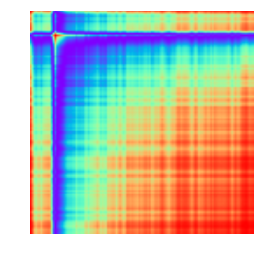

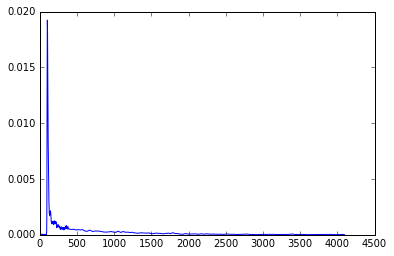

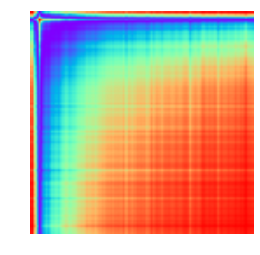

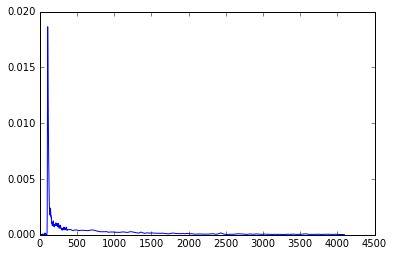

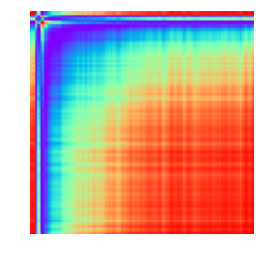

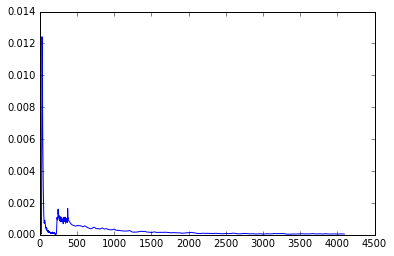

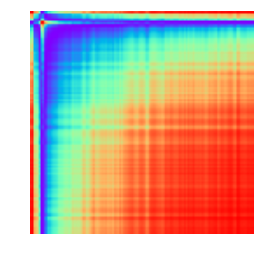

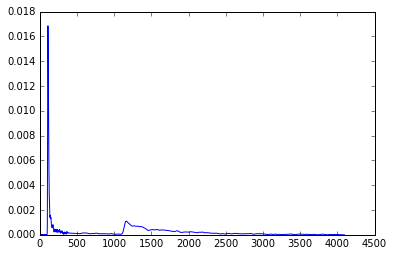

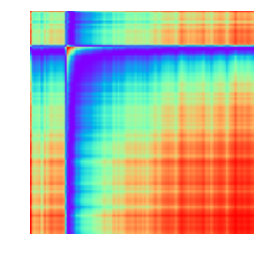

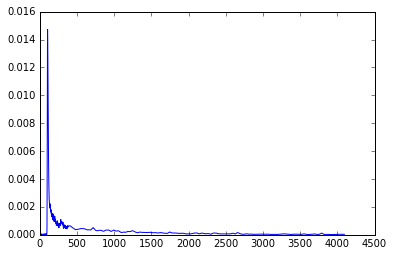

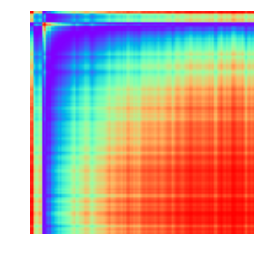

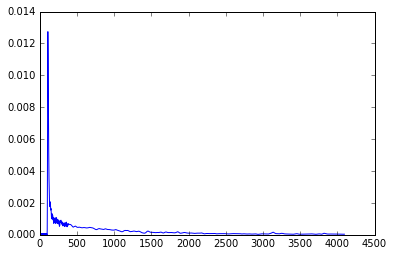

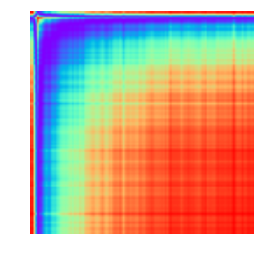

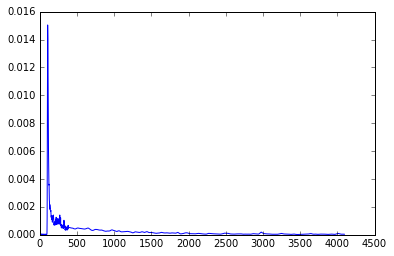

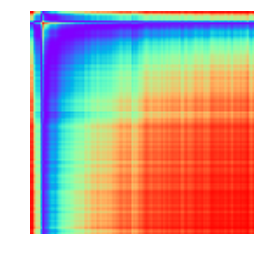

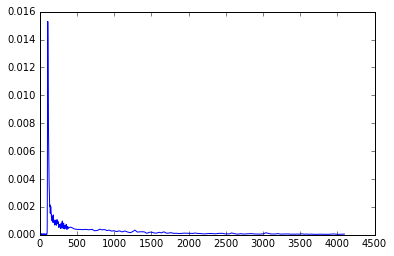

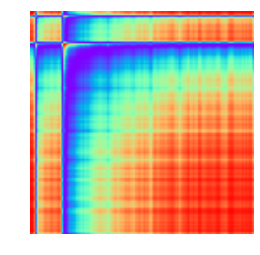

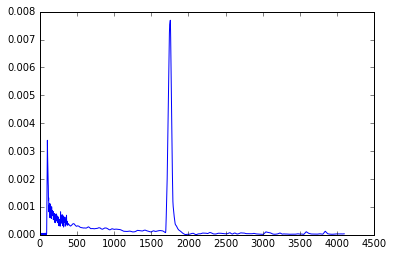

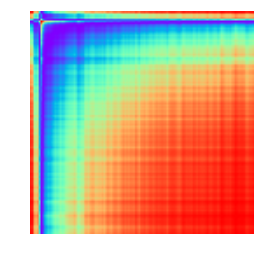

picked 520 events!


In [21]:
print("Starts picking!")
picked3 = []
for i in range(len(energy)):
    if indices[i]==3 and uncertain[i]<0.1:
        picked3.append(i)
for i in range(20):
    k = np.random.randint(len(picked3))
    plt.figure()
    plt.plot(np.arange(4096),pmtall[picked3[k]])
    plt.savefig("plots/ls_{}.png".format(i))
    plt.show()
    plt.figure()
    plot_gasf(pmtall[picked0[k]], image_size=128, overlapping=False, scale='-1')
    plt.savefig("gasf/ls_{}".format(i))
    plt.show()
print("picked",len(picked3), "events!")

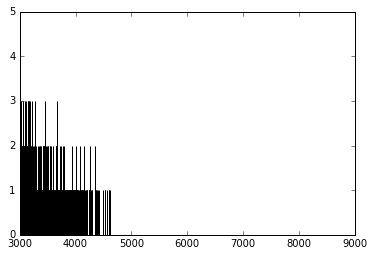

In [13]:
plt.figure()
plt.hist(energy[picked3,1],bins=np.arange(3000,9000,1))
# plt.yscale("log")
plt.show()

##### label = 4

Starts picking!


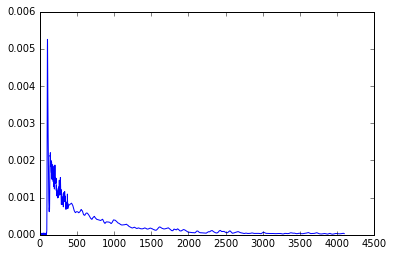

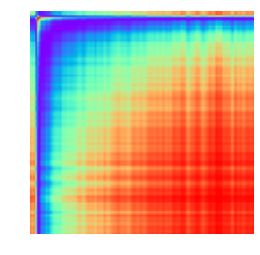

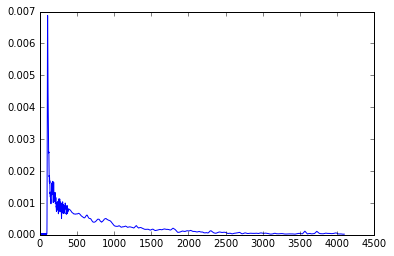

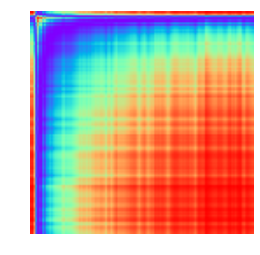

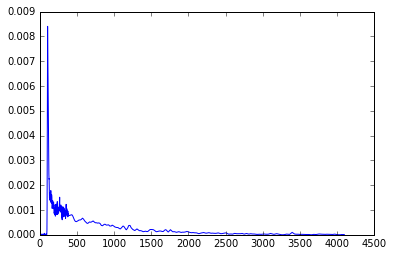

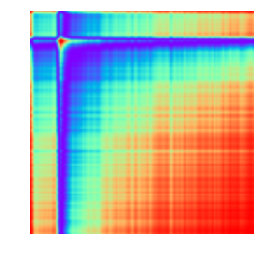

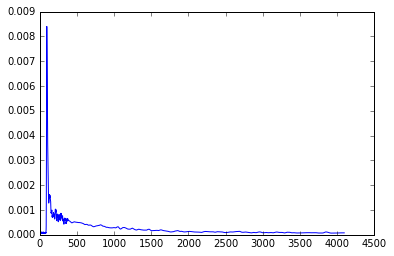

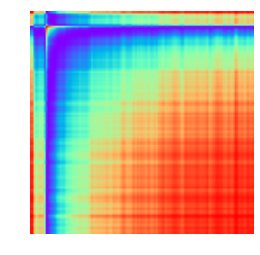

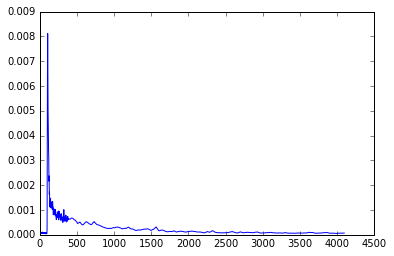

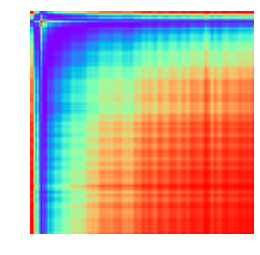

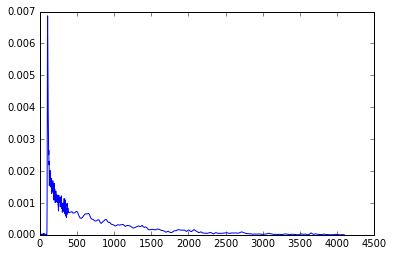

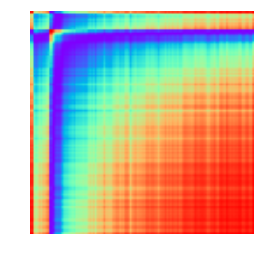

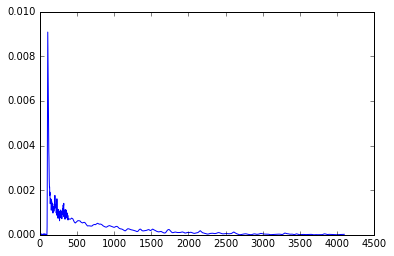

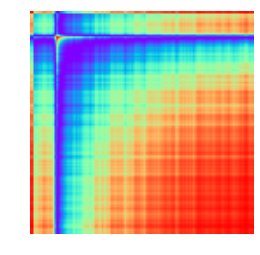

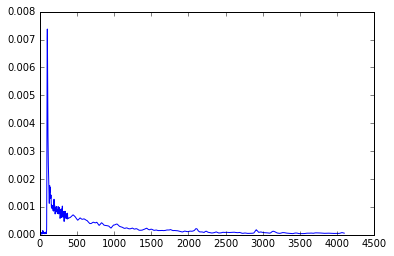

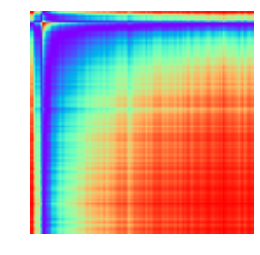

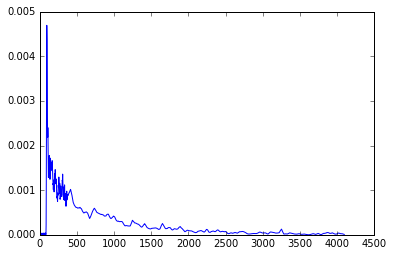

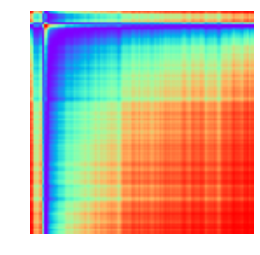

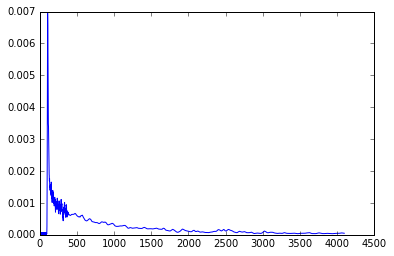

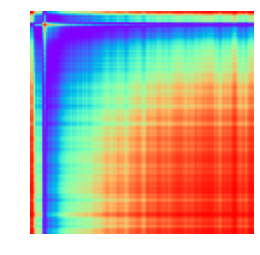

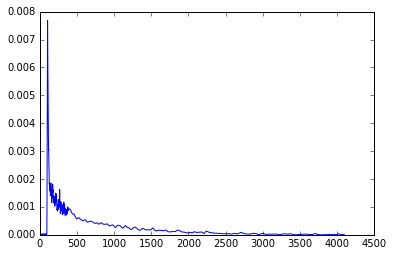

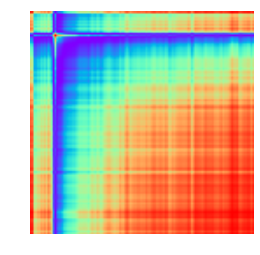

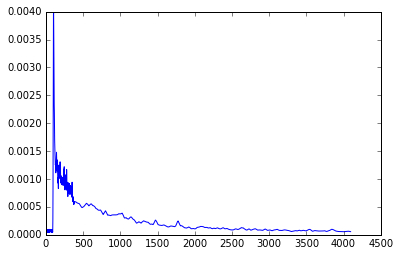

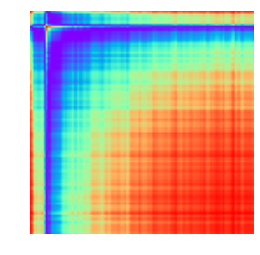

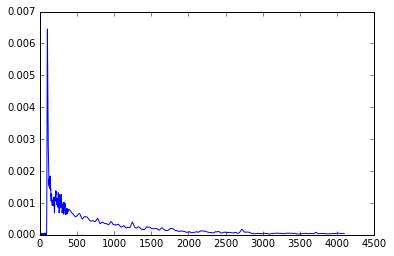

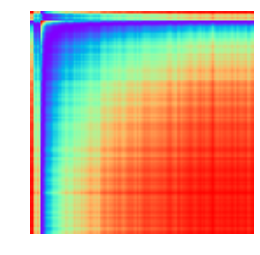

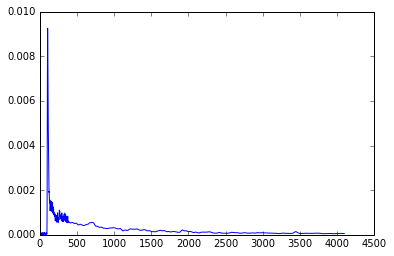

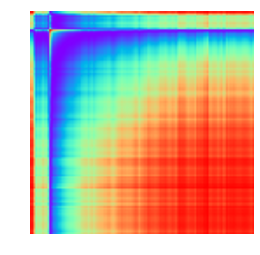

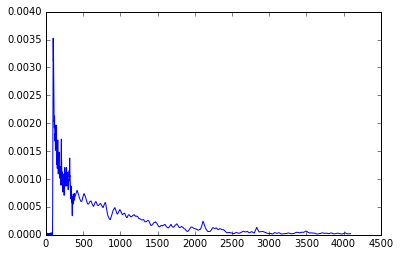

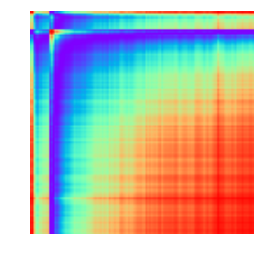

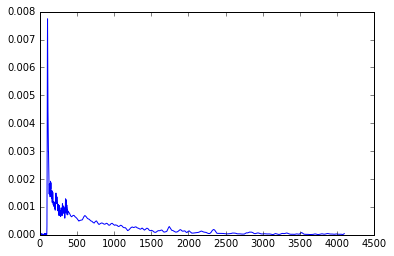

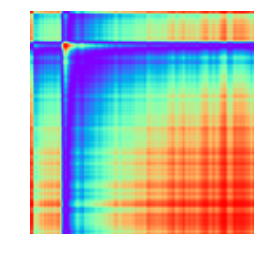

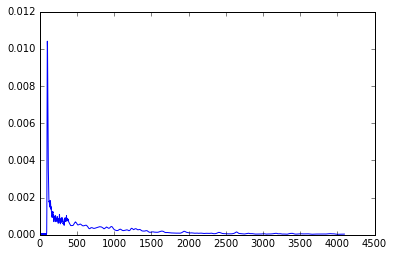

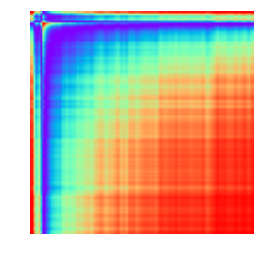

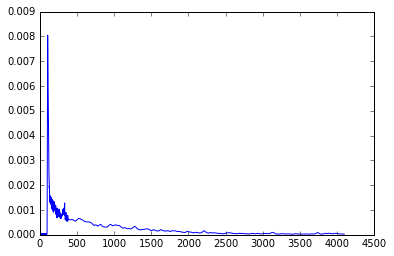

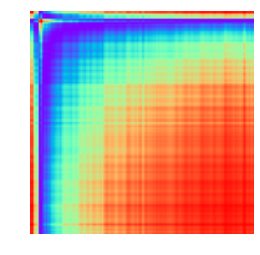

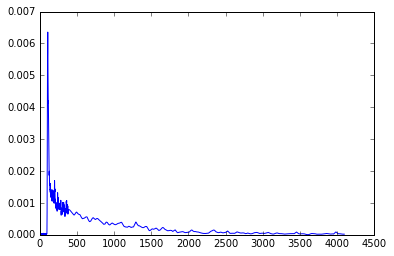

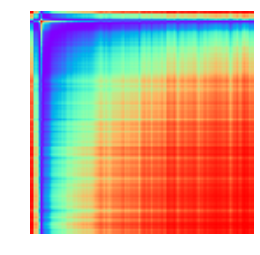

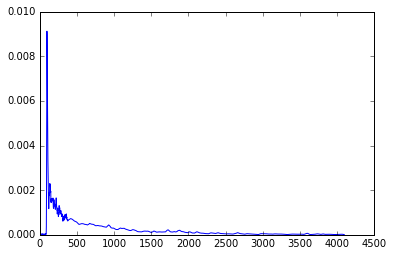

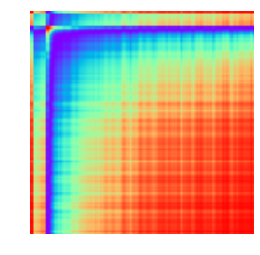

picked 6917 events!


In [22]:
print("Starts picking!")
picked4 = []
for i in range(len(energy)):
    if indices[i]==4 and uncertain[i]<0.1:
        picked4.append(i)
for i in range(20):
    k = np.random.randint(len(picked4))
    plt.figure()
    plt.plot(np.arange(4096),pmtall[picked4[k]])
    plt.savefig("plots/lsbe_{}.png".format(i))
    plt.show()
    plt.figure()
    plot_gasf(pmtall[picked0[k]], image_size=128, overlapping=False, scale='-1')
    plt.savefig("gasf/lsbe_{}".format(i))
    plt.show()

print("picked",len(picked4), "events!")

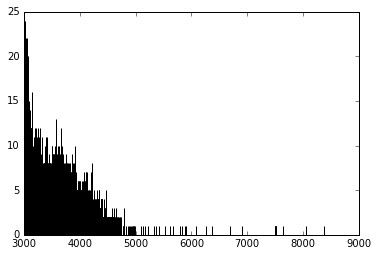

In [15]:
plt.figure()
plt.hist(energy[picked4,1],bins=np.arange(3000,9000,1))
# plt.yscale("log")
plt.show()

##### label = 5

In [14]:
print("Starts picking!")
picked5 = []
for i in range(len(energy)):
    if indices[i]==5 and uncertain[i]<0.1:
        picked5.append(i)
print(len(picked5))
for i in range(20):
    k = np.random.randint(len(picked5))
    plt.figure()
    plt.plot(np.arange(4096),pmtall[picked5[k]])
    plt.show()

print("picked",len(picked5), "events!")

Starts picking!
0


ValueError: low >= high

In [ ]:
plt.figure()
plt.hist(energy[picked5,1],bins=np.arange(3000,9000,1))
# plt.yscale("log")
plt.show()

##### label = 6

In [ ]:
print("Starts picking!")
picked6 = []
for i in range(len(energy)):
    if indices[i]==6 and uncertain[i]<0.1:
        picked6.append(i)
print(len(picked6))
for i in range(20):
    k = np.random.randint(len(picked6))
    plt.figure()
    plt.plot(np.arange(4096),pmtall[picked6[k]])
    plt.show()

print("picked",len(picked6), "events!")

In [ ]:
plt.figure()
plt.hist(energy[picked6],bins=np.arange(0,6000,5))
# plt.yscale("log")
plt.show()

### Combined all histogram

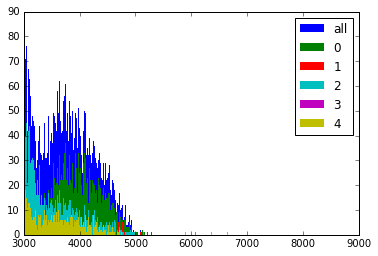

In [18]:
plt.figure()
plt.hist(energy[:,1],bins=np.arange(3000,9000,1),edgecolor='none',label="all")
plt.hist(energy[picked0,1],bins=np.arange(3000,9000,1),edgecolor='none',label="0")
plt.hist(energy[picked1,1],bins=np.arange(3000,9000,1),edgecolor='none',label="1")
plt.hist(energy[picked2,1],bins=np.arange(3000,9000,1),edgecolor='none',label="2")
plt.hist(energy[picked3,1],bins=np.arange(3000,9000,1),edgecolor='none',label="3")
plt.hist(energy[picked4,1],bins=np.arange(3000,9000,1),edgecolor='none',label="4")
# plt.hist(energy[picked5,1],bins=np.arange(0,6000,5),edgecolor='none',label="5")
# plt.hist(energy[picked6,1],bins=np.arange(0,6000,5),edgecolor='none',label="6",color="grey")
# plt.yscale("log")
plt.legend()
plt.show()

# Rewrite some portion

In [ ]:
%%time
# pmt_all_length = 4480

arguments = sys.argv
Run = arguments[0]
SubRun = arguments[1]
SubSubRun = arguments[2]

file = "Run{}/Run{}-{}-{}.root".format(Run,SubRun,SubSubRun)
data = "PMTALL"
tree = "tree"

pred = model.predict_generator(PMTALL,batch_size=200,verbose=1)


# output = open("DoubleP/Run{}-{}-{}.txt".format(Run,SubRun,SubSubRun), "w") 
# histo = ""

# def NORM(file, tree, data):
#     pmtall = read_root(file, tree, columns=[data],flatten=[data])
#     num_entries, w = pmtall.shape
#     num_entries = int(num_entries/pmt_all_length)
#     x = pmtall.PMTALL.values.reshape(num_entries, pmt_all_length)
#     x_abs = abs(x - 15200)
#     extra = np.arange(4160, pmt_all_length)
#     x_mod = np.delete(x_abs, extra, axis=1)
#     x_nor = normalize(x_mod, norm="l1")
#     return x_nor

# def read_para(x,tree,para):
#     ene = read_root(x, tree, columns=[para], flatten=[para])
#     num_entries, w = ene.shape
#     num_entries = int(num_entries/3)
#     y = ene.Energy.values.reshape(num_entries,3)
#     y_1 = np.expand_dims(y[:,1],axis=1)
#     y_1 = np.rint(y_1)
#     return y_1

from keras.models import load_model

model = load_model("CNN_d.h5")

PMTALL = NORM(file, tree, data)
# PMTALL = np.expand_dims(PMTALL,axis=2)
steps = len(PMTALL)
pred = model.predict_generator(PMTALL,batch_size=200,verbose=1)

del PMTALL

indices = np.argmax(pred,axis=1)

eventid = read_root(file, tree, columns=["EventID"], flatten=["EventID"])

energy = read_root(file, tree, columns=["Energy"],flatten=["Energy"])
l,h = energy.shape
li=int(l/3)
def reshape_Energy(x,n,l):
    return x.Energy.values.reshape(n,l)
energy = reshape_Energy(energy,li,3)
Energy = energy[:,1]

del energy

Energy = np.expand_dims(Energy, axis=1)
histogramming = np.array([])

for i in range(len(pred)):
    if indices[i]==0:
        output.write("{} {} {} {}".format(Run,SubRun,SubSubRun,EventID[i]))
        histogramming = np.concatenate((histogramming, Energy[i]), axis=0)
        
histogramming.to_root('Run{}-{}-{}.root'.format(Run,SubRun,SubSubRun), key='tree')
        
output.close()
